# Customer Segmentation Project

- **Objective:**

The objective of this data science project is to perform customer segmentation analysis using online sales
data. By analyzing customer behavior and characteristics, the project aims to identify distinct customer segments. This segmentation can help in targeted marketing strategies, personalized recommendations, and improving overall customer experience.

# Import necessary packages

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load the data 
df = pd.read_excel("..\Customer Segmentation\Data\Online Retail.xlsx")
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# Understand the Data

Before analyzing the data, it's crucial to gain a thorough understanding of its structure, content, and quality. This step involves examining the dataset's features, identifying missing values or anomalies, and understanding the context in which the data was collected. By understanding the data, we can make informed decisions about data preprocessing and analysis techniques.

In [3]:
# to know about data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


# Data Preprocessing

# Handling missing values

In [4]:
#null values in each variable
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

- In this project, the objective is to perform customer segmentation using online sales data. However, there are missing values in the Customer ID and Description columns. Since we are unable to recollect this missing data, the decision has been made to remove the rows where Customer IDs are null. This data preprocessing step is necessary to ensure the quality of the data for accurate customer segmentation analysis.

In [5]:
print("Shape of data before removing NaN's CustomerID",df.shape)
df_clean = df.dropna(subset='CustomerID')
print("Shape of data after removing NaN's CustomerID",df_clean.shape)

Shape of data before removing NaN's CustomerID (541909, 8)
Shape of data after removing NaN's CustomerID (406829, 8)


In [6]:
# Null Value details in Cleaned dataset
df_clean.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

# Fixing Data Types:
- To ensure the appropriate data types are used based on the dataset, we will convert the **CustomerID** variable from numeric to a categorical variable. In this dataset, **CustomerID** serves as the key value representing each customer.

In [7]:
df_clean['CustomerID'] = df_clean['CustomerID'].astype(str)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.9+ MB


# Feature Engineering

In [8]:
# To determine the actual spend of each item, we will create a new column called "Cost." This column will represent the total cost of each item, taking into account factors such as quantity and unit price.
df_clean['TotalAmount'] = df_clean['Quantity'] * df_clean['UnitPrice']
df_clean.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


# RFM Analysis

In [11]:
# Calculate Recency, Frequency, and Monetary values
snapshot_date = df_clean['InvoiceDate'].max() + pd.DateOffset(days=1)

rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalAmount': 'Monetary'
})

# Print the RFM dataframe
print(rfm.head())


            Recency  Frequency  Monetary
CustomerID                              
12346.0         326          2      0.00
12347.0           2          7   4310.00
12348.0          75          4   1797.24
12349.0          19          1   1757.55
12350.0         310          1    334.40


# RFM Quartiles

In [16]:
# Remove duplicate values from the Frequency column
rfm = rfm.drop_duplicates('Frequency')

# Create quartiles for Recency, Frequency, and Monetary
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)

rfm['R'] = pd.qcut(rfm['Recency'], q=4, labels=r_labels)
rfm['F'] = pd.qcut(rfm['Frequency'], q=4, labels=f_labels)
rfm['M'] = pd.qcut(rfm['Monetary'], q=4, labels=m_labels)

# Concatenate RFM quartile values to create RFM segments
rfm['RFM_Segment'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

# Calculate RFM score
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis=1)

# Print the RFM dataframe with segments and scores
print(rfm.head())


            Recency  Frequency  Monetary  R  F  M RFM_Segment  RFM_Score
CustomerID                                                              
12346.0         326          2      0.00  1  1  1         111          3
12347.0           2          7   4310.00  4  1  1         411          6
12348.0          75          4   1797.24  1  1  1         111          3
12349.0          19          1   1757.55  1  1  1         111          3
12352.0          36         11   1545.41  1  1  1         111          3


# Analyze RFM Segments

             Recency  Frequency  Monetary
RFM_Segment                              
111             60.3        8.3    2333.1
122             26.5       24.0    6766.4
123             15.0       27.0   13677.6
124             24.0       26.0  123725.4
144             28.0       75.5   42399.2
211              9.0       11.0    2432.2
212              6.5        8.0    5831.7
222             10.5       25.0    5649.0
223              5.0       32.0   11216.8
232              7.0       38.0    9623.4
233              9.0       36.0   16293.1
244             10.0       66.0  113384.1
311              3.0       12.0    3578.8
312              3.0       13.0    5154.6
321              3.0       25.0    4075.4
322              3.0       29.0    5713.3
323              4.0       31.0   12288.2
332              4.0       45.0    8740.8
333              4.0       48.0   15347.7
334              3.7       44.3   47116.5
342              3.0       86.0    7711.4
343              4.0       89.0   

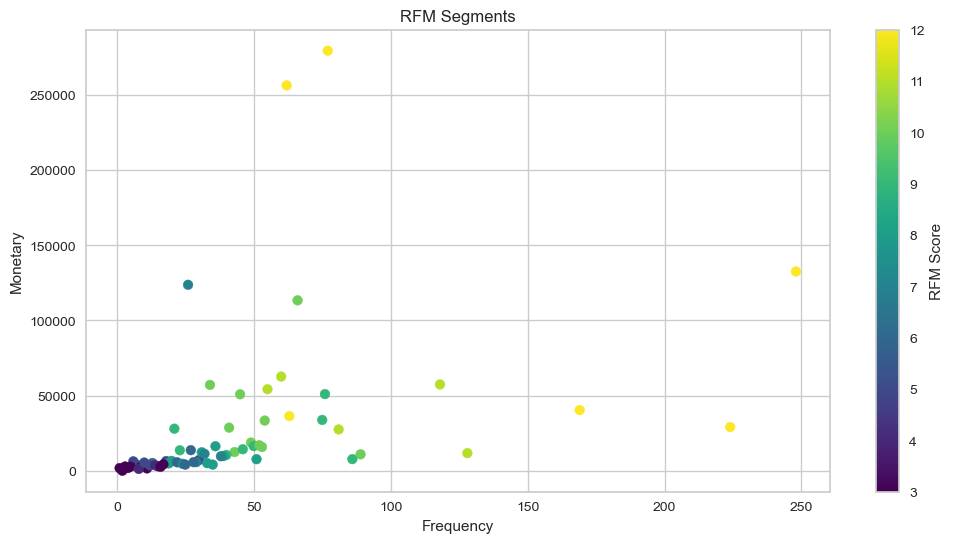

In [17]:
# Calculate average RFM values for each segment
rfm_agg = rfm.groupby('RFM_Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(1)

# Print the aggregated RFM values
print(rfm_agg)

# Visualize RFM segments
rfm['RFM_Score'] = rfm['RFM_Score'].astype(int)
plt.figure(figsize=(12, 6))
plt.scatter(rfm['Frequency'], rfm['Monetary'], c=rfm['RFM_Score'], cmap='viridis')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('RFM Segments')
plt.colorbar(label='RFM Score')
plt.show()


# RFM Clustering

# Determine the Optimal Number of Clusters

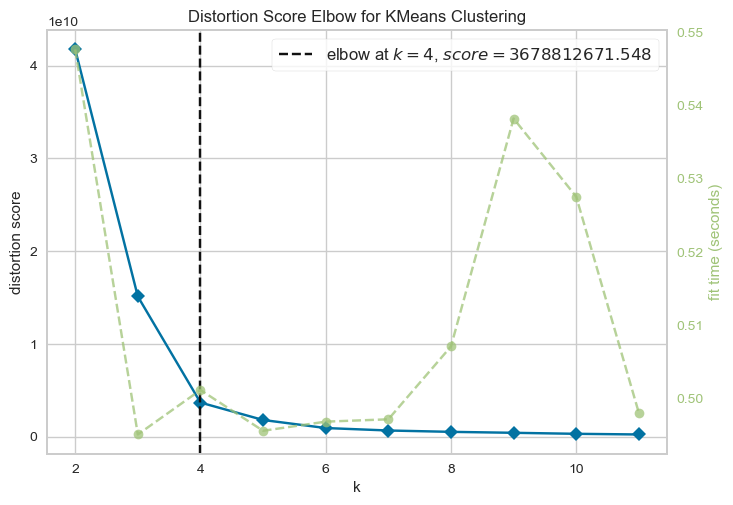

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [18]:
# Extract RFM values for clustering
X = rfm[['Recency', 'Frequency', 'Monetary']]

# Instantiate the KElbowVisualizer with the KMeans model
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

# Fit the visualizer and display the plot
visualizer.fit(X)
visualizer.show()


# Apply KMeans Clustering

In [19]:
# Choose the optimal number of clusters based on the elbow method
n_clusters = visualizer.elbow_value_

# Instantiate KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit KMeans to the RFM data
rfm['Cluster'] = kmeans.fit_predict(X)


# Visualize Clusters

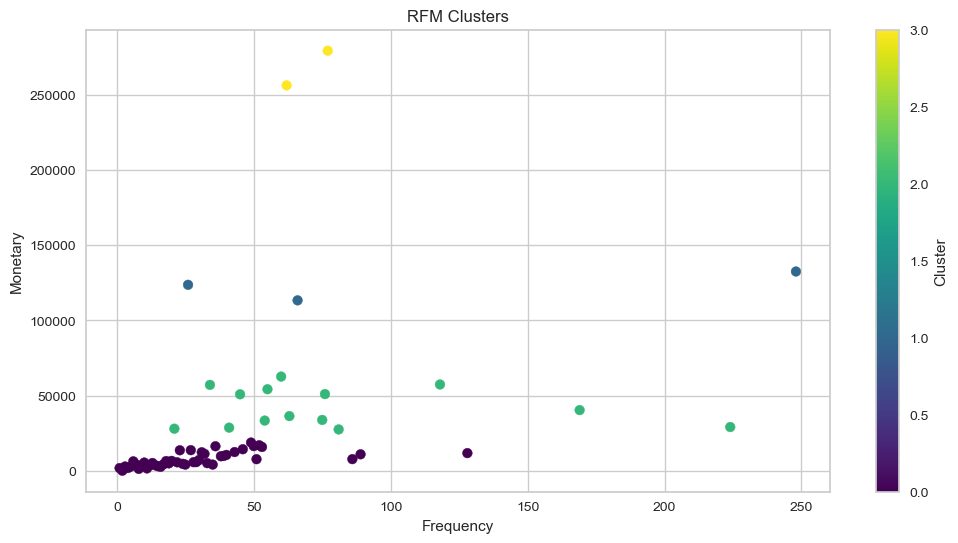

In [20]:
# Plot the clusters
plt.figure(figsize=(12, 6))
scatter = plt.scatter(rfm['Frequency'], rfm['Monetary'], c=rfm['Cluster'], cmap='viridis')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('RFM Clusters')
plt.colorbar(scatter, label='Cluster')
plt.show()


# Analyze Cluster Characteristics

In [21]:
# Calculate average RFM values for each cluster
cluster_avg = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(1)

# Print the average RFM values for each cluster
print(cluster_avg)


         Recency  Frequency  Monetary
Cluster                              
0           17.5       29.3    7442.2
1           11.7      113.3  123227.4
2            6.1       79.7   42163.6
3            1.5       69.5  267963.8


In [22]:
rfm

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,Cluster
CustomerID,,,,,,,,,
12346.0,326,2,0.00,1,1,1,111,3,0
12347.0,2,7,4310.00,4,1,1,411,6,0
12348.0,75,4,1797.24,1,1,1,111,3,0
12349.0,19,1,1757.55,1,1,1,111,3,0
12352.0,36,11,1545.41,1,1,1,111,3,0
...,...,...,...,...,...,...,...,...,...
16133.0,4,46,14305.66,3,3,3,333,9,0
16422.0,17,75,33805.69,1,4,4,144,9,2
17811.0,4,51,7677.71,3,3,2,332,8,0
